# Modeling using lightgbm
- Training and testing

In [ ]:
! python -m pip install lightgbm

Looking in indexes: https://pypi.ginkgobioworks.com/simple/
     |████████████████████████████████| 2.0 MB 13.0 MB/s eta 0:00:01


In [ ]:
import sys
print("Python version")
print (sys.version)

Python version
3.6.13 |Anaconda, Inc.| (default, Jun  4 2021, 14:25:59) 
[GCC 7.5.0]


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import pandas as pd
import sklearn
import numpy as np
from numpy import sqrt
from numpy import argmax
from scipy import stats
import os
import pickle
import itertools
from sklearn import linear_model, preprocessing
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split, KFold, GroupKFold
from sklearn.metrics import explained_variance_score, r2_score, mean_squared_error
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import IsolationForest
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_fscore_support, auc, average_precision_score, precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import manifold
from sklearn.decomposition import PCA, FastICA, TruncatedSVD, SparsePCA, sparse_encode, FactorAnalysis, KernelPCA
import time

from sklearn.model_selection import KFold, train_test_split, GridSearchCV
import xgboost as xgb

In [ ]:
pd.set_option('display.max_columns', None)

## Load cleaned dataset

In [ ]:
train_df = pd.read_csv('data/training_cleaned_v5.csv', index_col='ID', nrows=100000)

In [ ]:
import lightgbm as lgb

## Make train/val/test sets

In [ ]:
X = train_df.iloc[:, 1:]
y = train_df.iloc[:, 0]

In [ ]:
# put 25% examples in val/test set
# Set random seed to ensure reproducible runs
RSEED = 7

X_train, X_temp, y_train, y_temp = train_test_split(X, 
                                                    y, 
                                                    stratify = y,
                                                    test_size = 0.25, 
                                                    random_state = RSEED)

X_val, X_test, y_val, y_test = train_test_split(X_temp, 
                                                y_temp, 
                                                stratify = y_temp,
                                                test_size = 0.5, 
                                                random_state = RSEED)

## Define training, plotting methods

In [ ]:
def evaluate_model(predict_train, predict_val, predict_test, probability_train, probability_val, probability_test, y_train, y_val, y_test, 
                   classes=['no_vacc', 'vacc'], normalize=False, title='Classifier', cmap=plt.cm.Oranges):
    
    """Compare machine learning model to baseline performance.
    - Computes statistics and shows ROC curve.
    - Plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`."""
    
    print(classification_report(y_test, predict_test, target_names=classes))
    
    #plot ROC
    baseline = {}
    
    baseline['recall'] = recall_score(y_test, [1 for _ in range(len(y_test))])
    baseline['precision'] = precision_score(y_test, [1 for _ in range(len(y_test))])
    baseline['auroc'] = 0.5

    train_results = {}
    train_results['recall'] = recall_score(y_train, predict_train)
    train_results['precision'] = precision_score(y_train, predict_train)
    train_results['auroc'] = roc_auc_score(y_train, probability_train)
    
    val_results = {}
    val_results['recall'] = recall_score(y_val, predict_val)
    val_results['precision'] = precision_score(y_val, predict_val)
    val_results['auroc'] = roc_auc_score(y_val, probability_val)
    
    test_results = {}
    test_results['recall'] = recall_score(y_test, predict_test)
    test_results['precision'] = precision_score(y_test, predict_test)
    test_results['auroc'] = roc_auc_score(y_test, probability_test)
    
#     for metric in ['recall', 'precision', 'auroc']:
#         print(f'{metric.capitalize():10s}--> Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    fpr_train, tpr_train, _ = roc_curve(y_train, probability_train)
    fpr_val, tpr_val, thresholds_val = roc_curve(y_val, probability_val)
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, probability_test)
    fpr_base, tpr_base, _ = roc_curve(y_test, [1 for _ in range(len(y_test))])
    
    # recalculate prediction
    gmeans = sqrt(tpr_val * (1-fpr_val))
    # locate the index of the largest g-mean
    ix = argmax(gmeans)
    T_val = thresholds_val[ix] #Best Threshold
    #print('thresholds_val', thresholds_val)
    print('T_val:', T_val)
    
    for i in range(len(thresholds_test)):
        if thresholds_test[i] < T_val:
            ix_test = i
            break
#     print('test', ix_test, thresholds_test[ix_test], thresholds_test[ix_test-1])
#     print('Best Threshold=%f, G-Mean=%.3f' % (T_val, gmeans[ix]))
    fig, axs = plt.subplots(1, 2, figsize = (10, 5), gridspec_kw={'width_ratios': [1, 1.2]})
    
    # Plot ROC curves
    axs[0].scatter(fpr_val[ix], tpr_val[ix], marker='o', color='#1E90FF', label='Best in val') # plot best val point
    axs[0].scatter((fpr_test[ix_test]+fpr_test[ix_test-1])/2, (tpr_test[ix_test]+tpr_test[ix_test-1])/2, marker='o', color='r', label='Best in test')# plot best test point
    
    axs[0].plot(fpr_train, tpr_train, '#32CD32', label = 'Train', linestyle='dashed')
    axs[0].plot(fpr_val, tpr_val, '#1E90FF', label = 'Validation')
    axs[0].plot(fpr_test, tpr_test, 'r', label = 'Test')
    axs[0].plot(fpr_base, tpr_base, '#8B4513', label = 'Baseline')
    
    axs[0].legend(prop={'size': 10}, loc = (0.60, 0.05))
    #axs[0].legend(prop={'size': 10}, loc='lower right')
    axs[0].set_xlabel('False Positive Rate', size = 16)
    axs[0].set_ylabel('True Positive Rate', size = 16)
    axs[0].set_title('ROC curves')
    axs[0].tick_params(axis='both', which='major', labelsize=14)
    
    Train_AUROC = roc_auc_score(y_train, probability_train)
    Test_AUROC = roc_auc_score(y_test, probability_test)
    
    axs[0].text(0.13,0.6, f'Train AUROC: {Train_AUROC:.4f}\nTest AUROC: {Test_AUROC:.4f}', fontsize=12 )
    
    print(f'Train AUROC: {Train_AUROC:.4f}')
    print(f'Test AUROC: {Test_AUROC:.4f}')
    
    # Plot confusion matrix heatmap
    predict_test = [1 if x > T_val else 0 for x in probability_test]
    cm = confusion_matrix(y_test, predict_test, labels=[0,1]) # counts
    cm2 = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # %

    im = axs[1].imshow(cm2, interpolation='nearest', cmap=cmap, vmin=0, vmax=1)
    axs[1].set_title('Confusion matrix (Test)')
    
    # Create colorbar
    cbar = axs[1].figure.colorbar(im, ax=axs[1])
    cbar.ax.tick_params(labelsize=12) 
    cbar.ax.set_ylabel('Fraction of true classes')
    
    # We want to show all ticks...
    axs[1].set_xticks(np.arange(len(classes)))
    axs[1].set_yticks(np.arange(len(classes)))
    tick_marks = np.arange(len(classes))
    axs[1].set_xticklabels(classes)
    axs[1].set_yticklabels(classes,rotation=90, va='center')
    axs[1].tick_params(axis='both', which='major', labelsize=14)
    
    thresh = cm2.max()*0.7
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f'{cm2[i, j]:.2f}\n({cm[i, j]:,d})',
                 fontsize = 14,
                 ha="center",
                 va='center',
                 color="white" if cm2[i, j] > thresh else "black")
    
    axs[1].set_ylabel('True label', size = 16)
    axs[1].set_xlabel('Predicted label', size = 16)
    
    fig.suptitle(title, fontsize="xx-large")
    plt.tight_layout()
    plt.savefig(f"best_models/Model_performance_{title.replace(' ', '_')}.pdf")
    return T_val

In [ ]:
def benchmark_classifiers(clf, model_name, X_train, X_val, X_test, y_train, y_val, y_test):
    print(f'----- Classification Report {model_name} -----')
    clf.fit(X_train, y_train, early_stopping_rounds=10, eval_metric="auc", eval_set=[(X_val, y_val)])
    probability_train = clf.predict_proba(X_train)[:, 1]
    probability_val = clf.predict_proba(X_val)[:, 1]
    probability_test = clf.predict_proba(X_test)[:, 1]
    predict_train = clf.predict(X_train)
    predict_val = clf.predict(X_val)
    predict_test = clf.predict(X_test)
    T_val = evaluate_model(predict_train, predict_val, predict_test, probability_train, probability_val, probability_test, y_train, y_val, y_test, normalize=True, title=model_name)
    return T_val

## Training

### Simple way

In [1]:
import shap

ModuleNotFoundError: ignored

In [ ]:
d_train = lgb.Dataset(X_train, label=y_train)
d_test = lgb.Dataset(X_test, label=y_test)

In [ ]:
params = {"boosting_type": "gbdt",
          "objective": "binary",
          "max_depth": 3,
         "metric": ["binary_logloss", 'auc'],
}


In [ ]:
model = lgb.train(params, d_train, 1000, valid_sets=[d_test], early_stopping_rounds=20, verbose_eval=1000)

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
shap_obj = explainer(X)

In [ ]:
shap.summary_plot(shap_values, X)

In [ ]:
# summarize the effects of all the features
shap.summary_plot(shap_obj)

In [ ]:
clf = lgb.LGBMClassifier(n_estimators=500, max_depth=3, early_stopping_rounds = 10, n_jobs=-1)

In [ ]:
clf.fit(X_train, y_train, early_stopping_rounds=10, eval_metric="auc", eval_set=[(X_temp, y_temp)])

In [ ]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer(X_train)

In [ ]:
explainer = shap.KernelExplainer(clf.predict,X_train)
shap_values = explainer.shap_values(X_train)

In [ ]:
! python -m pip install shap

In [ ]:
import shap

In [ ]:
explainer = shap.TreeExplainer(clf_list['LGBMClassifier_1000x3 v5'], X_test.sample(1000))
shap_values = explainer(X_test.reset_index(drop=True))

In [ ]:
type(shap_values)

In [ ]:
shap_values = shap.KernelExplainer(clf_list['LGBMClassifier_1000x3 v5'].predict, X_test)

In [ ]:
type(shap_values)

In [ ]:
knn_explainer = shap.KernelExplainer(knn.predict,X_test)
knn_shap_values = knn_explainer.shap_values(X_test)

In [ ]:
X_test.shape

In [ ]:
shap.summary_plot(shap_values, X_train)

In [ ]:
shap.summary_plot(shap_values[1], X_test.values, feature_names = X_test.columns)

In [ ]:
shap.summary_plot(shap_values, X_test, class_names = ['no_vacc', 'vacc'], feature_names = X_test.columns,  max_display=10, plot_size=(8,8))

In [ ]:
# visualize the first prediction's explanation
shap.plots.waterfall(shap_values)

In [ ]:
! python -m pip install shap

In [ ]:
import shap

In [ ]:
explainer = shap.TreeExplainer(clf_list['LGBMClassifier_1000x3 v5'], X_test.sample(1000))
shap_values = explainer(X_test.reset_index(drop=True))

In [ ]:
type(shap_values)

In [ ]:
shap_values = shap.KernelExplainer(clf_list['LGBMClassifier_1000x3 v5'].predict, X_test)

In [ ]:
type(shap_values)

In [ ]:
knn_explainer = shap.KernelExplainer(knn.predict,X_test)
knn_shap_values = knn_explainer.shap_values(X_test)

In [ ]:
X_test.shape

In [ ]:
shap.summary_plot(shap_values, X_test)

In [ ]:
shap.summary_plot(shap_values[1], X_test.values, feature_names = X_test.columns)

In [ ]:
shap.summary_plot(shap_values, X_test, class_names = ['no_vacc', 'vacc'], feature_names = X_test.columns,  max_display=10, plot_size=(8,8))

In [ ]:
# visualize the first prediction's explanation
shap.plots.waterfall(shap_values)

In [ ]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values)

In [ ]:
X_test.shape

In [ ]:
shap.summary_plot(shap_values, X_test)

In [ ]:
shap.summary_plot(shap_values[1], X_test.values, feature_names = X_test.columns)

In [ ]:
shap.summary_plot(shap_values, X_test, class_names = ['no_vacc', 'vacc'], feature_names = X_test.columns,  max_display=10, plot_size=(8,8))

In [ ]:
# visualize the first prediction's explanation
shap.plots.waterfall(shap_values)

In [ ]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values)

### old way

In [ ]:
clf_list = {}
n_estimators = 1000
for max_depth in (1, 2, 3, 4, 5, 6, 7, 8, 9, 10):
    clf_list[f'LGBMClassifier_{n_estimators}x{max_depth} v5'] = lgb.LGBMClassifier(n_estimators=n_estimators, max_depth = max_depth, early_stopping_rounds=10, n_jobs=-1, random_state = RSEED)

# for n_estimators in (50, 100, 200, 500):
#     for max_depth in (4, 6, 8, 10, 15):
#         clf_list[f'XGBRFClassifier_{n_estimators}x{max_depth} v5'] = xgb.XGBRFClassifier(n_estimators=n_estimators, max_depth = max_depth, n_jobs=-1, use_label_encoder=False, random_state = RSEED)

----- Classification Report LGBMClassifier_1000x1 v5 -----


/home/ywang/miniconda3/envs/python36/lib/python3.6/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's auc: 0.554135	valid_0's binary_logloss: 0.460907
Training until validation scores don't improve for 10 rounds
[2]	valid_0's auc: 0.554135	valid_0's binary_logloss: 0.460082
[3]	valid_0's auc: 0.555065	valid_0's binary_logloss: 0.459402
[4]	valid_0's auc: 0.583924	valid_0's binary_logloss: 0.458782
[5]	valid_0's auc: 0.600689	valid_0's binary_logloss: 0.458231
[6]	valid_0's auc: 0.600777	valid_0's binary_logloss: 0.45768
[7]	valid_0's auc: 0.606578	valid_0's binary_logloss: 0.457159
[8]	valid_0's auc: 0.606539	valid_0's binary_logloss: 0.456664
[9]	valid_0's auc: 0.615708	valid_0's binary_logloss: 0.456204
[10]	valid_0's auc: 0.62222	valid_0's binary_logloss: 0.455749
[11]	valid_0's auc: 0.623772	valid_0's binary_logloss: 0.45534
[12]	valid_0's auc: 0.625113	valid_0's binary_logloss: 0.454909
[13]	valid_0's auc: 0.625134	valid_0's binary_logloss: 0.454538
[14]	valid_0's auc: 0.627873	valid_0's binary_logloss: 0.454165
[15]	valid_0's auc: 0.626897	valid_0's binary_logloss: 

/home/ywang/miniconda3/envs/python36/lib/python3.6/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[1]	valid_0's auc: 0.587608	valid_0's binary_logloss: 0.460355
Training until validation scores don't improve for 10 rounds
[2]	valid_0's auc: 0.604676	valid_0's binary_logloss: 0.458979
[3]	valid_0's auc: 0.615095	valid_0's binary_logloss: 0.457827
[4]	valid_0's auc: 0.617371	valid_0's binary_logloss: 0.456771
[5]	valid_0's auc: 0.625731	valid_0's binary_logloss: 0.455798
[6]	valid_0's auc: 0.626617	valid_0's binary_logloss: 0.454891
[7]	valid_0's auc: 0.627829	valid_0's binary_logloss: 0.454111
[8]	valid_0's auc: 0.629007	valid_0's binary_logloss: 0.453373
[9]	valid_0's auc: 0.632003	valid_0's binary_logloss: 0.452663
[10]	valid_0's auc: 0.632905	valid_0's binary_logloss: 0.452022
[11]	valid_0's auc: 0.634561	valid_0's binary_logloss: 0.451467
[12]	valid_0's auc: 0.636177	valid_0's binary_logloss: 0.450852
[13]	valid_0's auc: 0.636207	valid_0's binary_

/home/ywang/miniconda3/envs/python36/lib/python3.6/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[1]	valid_0's auc: 0.604684	valid_0's binary_logloss: 0.459821
Training until validation scores don't improve for 10 rounds
[2]	valid_0's auc: 0.610818	valid_0's binary_logloss: 0.458065
[3]	valid_0's auc: 0.621688	valid_0's binary_logloss: 0.456536
[4]	valid_0's auc: 0.630417	valid_0's binary_logloss: 0.455218
[5]	valid_0's auc: 0.632727	valid_0's binary_logloss: 0.453973
[6]	valid_0's auc: 0.635243	valid_0's binary_logloss: 0.452872
[7]	valid_0's auc: 0.636719	valid_0's binary_logloss: 0.451861
[8]	valid_0's auc: 0.638188	valid_0's binary_logloss: 0.450985
[9]	valid_0's auc: 0.641739	valid_0's binary_logloss: 0.450076
[10]	valid_0's auc: 0.64296	valid_0's binary_logloss: 0.449322
[11]	valid_0's auc: 0.643835	valid_0's binary_logloss: 0.448625
[12]	valid_0's auc: 0.644975	valid_0's binary_logloss: 0.447952
[13]	valid_0's auc: 0.646728	valid_0's binary_l

/home/ywang/miniconda3/envs/python36/lib/python3.6/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[1]	valid_0's auc: 0.61988	valid_0's binary_logloss: 0.459387
Training until validation scores don't improve for 10 rounds
[2]	valid_0's auc: 0.623866	valid_0's binary_logloss: 0.457353
[3]	valid_0's auc: 0.635726	valid_0's binary_logloss: 0.455387
[4]	valid_0's auc: 0.640443	valid_0's binary_logloss: 0.453738
[5]	valid_0's auc: 0.644117	valid_0's binary_logloss: 0.452266
[6]	valid_0's auc: 0.645794	valid_0's binary_logloss: 0.451041
[7]	valid_0's auc: 0.648532	valid_0's binary_logloss: 0.449889
[8]	valid_0's auc: 0.65044	valid_0's binary_logloss: 0.448765
[9]	valid_0's auc: 0.651525	valid_0's binary_logloss: 0.447849
[10]	valid_0's auc: 0.653274	valid_0's binary_logloss: 0.446871
[11]	valid_0's auc: 0.654037	valid_0's binary_logloss: 0.446145
[12]	valid_0's auc: 0.655685	valid_0's binary_logloss: 0.445336
[13]	valid_0's auc: 0.656695	valid_0's binary_lo

/home/ywang/miniconda3/envs/python36/lib/python3.6/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[1]	valid_0's auc: 0.629124	valid_0's binary_logloss: 0.45903
Training until validation scores don't improve for 10 rounds
[2]	valid_0's auc: 0.634319	valid_0's binary_logloss: 0.45671
[3]	valid_0's auc: 0.64426	valid_0's binary_logloss: 0.454465
[4]	valid_0's auc: 0.645877	valid_0's binary_logloss: 0.452669
[5]	valid_0's auc: 0.649428	valid_0's binary_logloss: 0.451032
[6]	valid_0's auc: 0.652757	valid_0's binary_logloss: 0.449528
[7]	valid_0's auc: 0.654633	valid_0's binary_logloss: 0.448262
[8]	valid_0's auc: 0.656596	valid_0's binary_logloss: 0.447082
[9]	valid_0's auc: 0.657417	valid_0's binary_logloss: 0.446119
[10]	valid_0's auc: 0.658783	valid_0's binary_logloss: 0.445149
[11]	valid_0's auc: 0.659474	valid_0's binary_logloss: 0.444359
[12]	valid_0's auc: 0.660339	valid_0's binary_logloss: 0.443609
[13]	valid_0's auc: 0.661383	valid_0's binary_log

/home/ywang/miniconda3/envs/python36/lib/python3.6/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[1]	valid_0's auc: 0.636738	valid_0's binary_logloss: 0.458737
Training until validation scores don't improve for 10 rounds
[2]	valid_0's auc: 0.641202	valid_0's binary_logloss: 0.456159
[3]	valid_0's auc: 0.646282	valid_0's binary_logloss: 0.453995
[4]	valid_0's auc: 0.649869	valid_0's binary_logloss: 0.452039
[5]	valid_0's auc: 0.653547	valid_0's binary_logloss: 0.450259
[6]	valid_0's auc: 0.655366	valid_0's binary_logloss: 0.448788
[7]	valid_0's auc: 0.657306	valid_0's binary_logloss: 0.447421
[8]	valid_0's auc: 0.658795	valid_0's binary_logloss: 0.446235
[9]	valid_0's auc: 0.660212	valid_0's binary_logloss: 0.445124
[10]	valid_0's auc: 0.661557	valid_0's binary_logloss: 0.444163
[11]	valid_0's auc: 0.662016	valid_0's binary_logloss: 0.443387
[12]	valid_0's auc: 0.662859	valid_0's binary_logloss: 0.442638
[13]	valid_0's auc: 0.663659	valid_0's binary_

/home/ywang/miniconda3/envs/python36/lib/python3.6/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[1]	valid_0's auc: 0.637914	valid_0's binary_logloss: 0.458658
Training until validation scores don't improve for 10 rounds
[2]	valid_0's auc: 0.642133	valid_0's binary_logloss: 0.45605
[3]	valid_0's auc: 0.647669	valid_0's binary_logloss: 0.453791
[4]	valid_0's auc: 0.651503	valid_0's binary_logloss: 0.451886
[5]	valid_0's auc: 0.652637	valid_0's binary_logloss: 0.450182
[6]	valid_0's auc: 0.655212	valid_0's binary_logloss: 0.448657
[7]	valid_0's auc: 0.656755	valid_0's binary_logloss: 0.447282
[8]	valid_0's auc: 0.658095	valid_0's binary_logloss: 0.446082
[9]	valid_0's auc: 0.6594	valid_0's binary_logloss: 0.445023
[10]	valid_0's auc: 0.660444	valid_0's binary_logloss: 0.44409
[11]	valid_0's auc: 0.661632	valid_0's binary_logloss: 0.443244
[12]	valid_0's auc: 0.662583	valid_0's binary_logloss: 0.442432
[13]	valid_0's auc: 0.663522	valid_0's binary_logl

/home/ywang/miniconda3/envs/python36/lib/python3.6/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[1]	valid_0's auc: 0.639463	valid_0's binary_logloss: 0.458641
Training until validation scores don't improve for 10 rounds
[2]	valid_0's auc: 0.642995	valid_0's binary_logloss: 0.456016
[3]	valid_0's auc: 0.648639	valid_0's binary_logloss: 0.453721
[4]	valid_0's auc: 0.652574	valid_0's binary_logloss: 0.451765
[5]	valid_0's auc: 0.653394	valid_0's binary_logloss: 0.450068
[6]	valid_0's auc: 0.655945	valid_0's binary_logloss: 0.448542
[7]	valid_0's auc: 0.657545	valid_0's binary_logloss: 0.447152
[8]	valid_0's auc: 0.659224	valid_0's binary_logloss: 0.445918
[9]	valid_0's auc: 0.660182	valid_0's binary_logloss: 0.444938
[10]	valid_0's auc: 0.661458	valid_0's binary_logloss: 0.44397
[11]	valid_0's auc: 0.66293	valid_0's binary_logloss: 0.443054
[12]	valid_0's auc: 0.663834	valid_0's binary_logloss: 0.442291
[13]	valid_0's auc: 0.664671	valid_0's binary_lo

/home/ywang/miniconda3/envs/python36/lib/python3.6/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[1]	valid_0's auc: 0.639771	valid_0's binary_logloss: 0.458619
Training until validation scores don't improve for 10 rounds
[2]	valid_0's auc: 0.643776	valid_0's binary_logloss: 0.455989
[3]	valid_0's auc: 0.647832	valid_0's binary_logloss: 0.453669
[4]	valid_0's auc: 0.652084	valid_0's binary_logloss: 0.45165
[5]	valid_0's auc: 0.653505	valid_0's binary_logloss: 0.449973
[6]	valid_0's auc: 0.654963	valid_0's binary_logloss: 0.448559
[7]	valid_0's auc: 0.656341	valid_0's binary_logloss: 0.447258
[8]	valid_0's auc: 0.657841	valid_0's binary_logloss: 0.446006
[9]	valid_0's auc: 0.659755	valid_0's binary_logloss: 0.444849
[10]	valid_0's auc: 0.661347	valid_0's binary_logloss: 0.44388
[11]	valid_0's auc: 0.662308	valid_0's binary_logloss: 0.443059
[12]	valid_0's auc: 0.663345	valid_0's binary_logloss: 0.442253
[13]	valid_0's auc: 0.664614	valid_0's binary_lo

/home/ywang/miniconda3/envs/python36/lib/python3.6/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[1]	valid_0's auc: 0.639264	valid_0's binary_logloss: 0.458623
Training until validation scores don't improve for 10 rounds
[2]	valid_0's auc: 0.643514	valid_0's binary_logloss: 0.455973
[3]	valid_0's auc: 0.648101	valid_0's binary_logloss: 0.453669
[4]	valid_0's auc: 0.652026	valid_0's binary_logloss: 0.451633
[5]	valid_0's auc: 0.65372	valid_0's binary_logloss: 0.449942
[6]	valid_0's auc: 0.655431	valid_0's binary_logloss: 0.448504
[7]	valid_0's auc: 0.657478	valid_0's binary_logloss: 0.447102
[8]	valid_0's auc: 0.659018	valid_0's binary_logloss: 0.445906
[9]	valid_0's auc: 0.659948	valid_0's binary_logloss: 0.444912
[10]	valid_0's auc: 0.661557	valid_0's binary_logloss: 0.443922
[11]	valid_0's auc: 0.662572	valid_0's binary_logloss: 0.443036
[12]	valid_0's auc: 0.6635	valid_0's binary_logloss: 0.442297
[13]	valid_0's auc: 0.664848	valid_0's binary_log

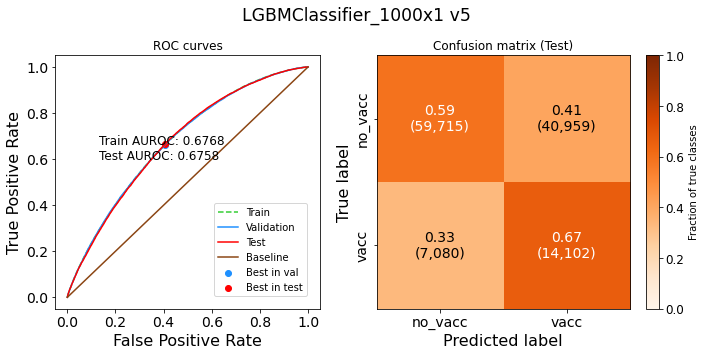

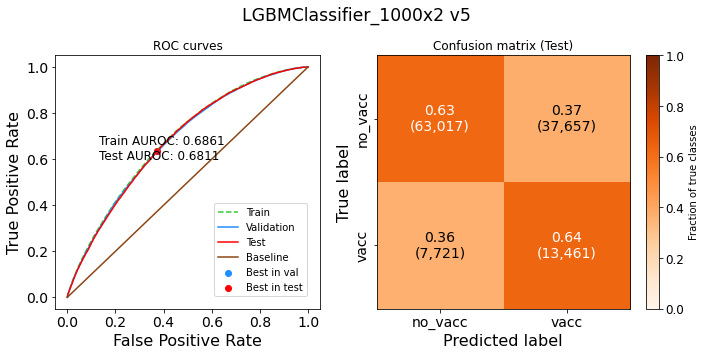

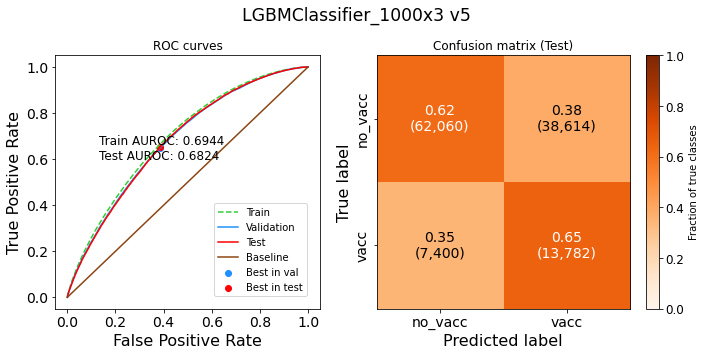

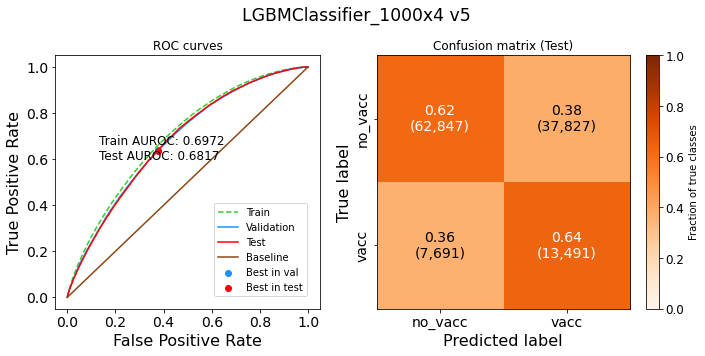

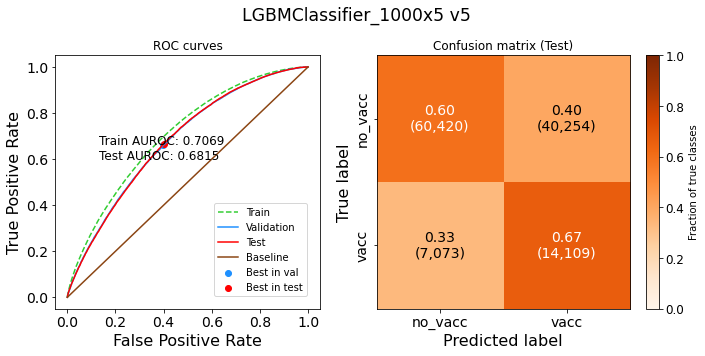

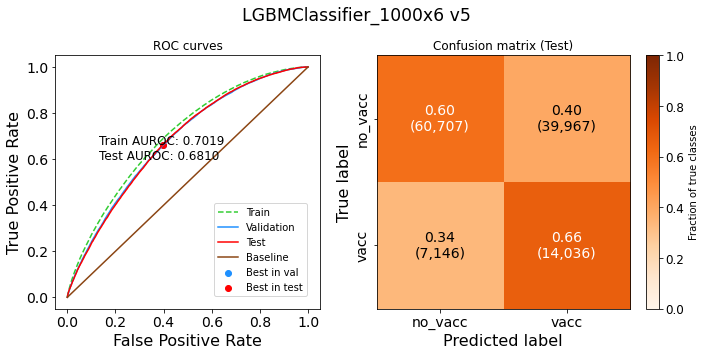

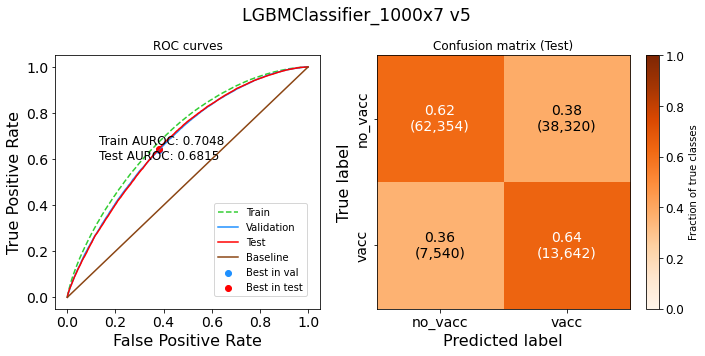

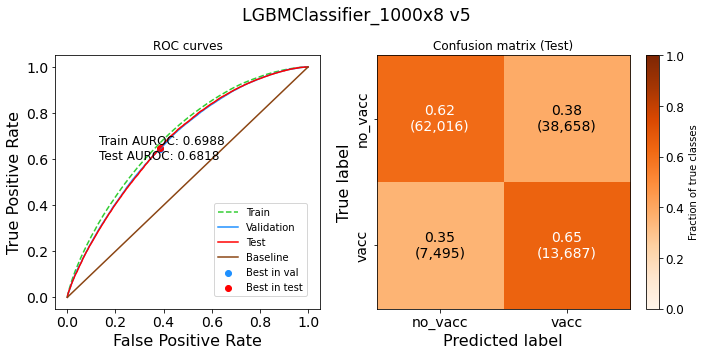

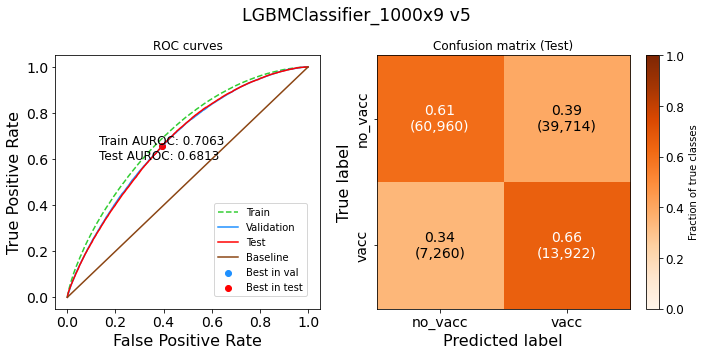

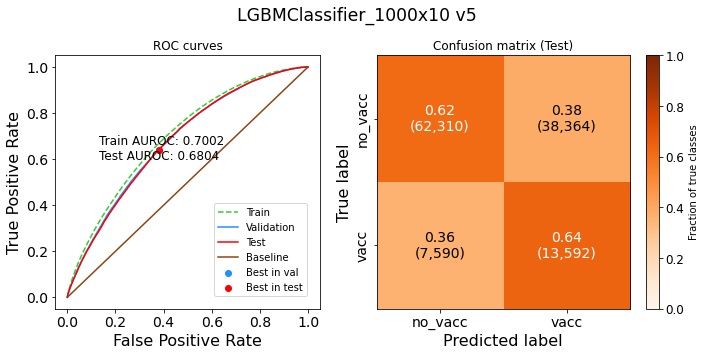

In [ ]:
clf_trained = {}
for clf_name in clf_list:
    clf = clf_list[clf_name]
    T_val = benchmark_classifiers(clf, clf_name, X_train, X_val, X_test, y_train, y_val, y_test)
    clf_trained[clf_name] = (clf, T_val)
    with open(f'best_models/{clf_name}_model.pk','wb') as ofile:
        pickle.dump((clf, T_val), ofile)
    print()

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

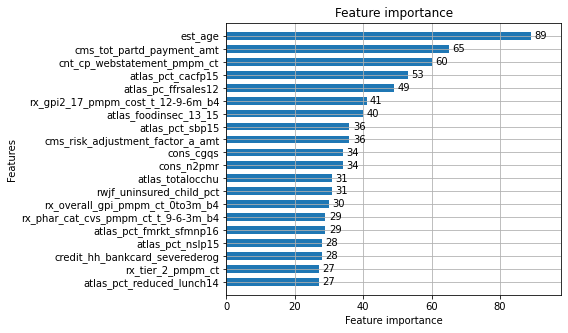

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (6, 5))
lgb.plot_importance(clf_list['LGBMClassifier_1000x3 v5'], max_num_features=20, height=0.6, ax=ax)

In [ ]:
clf_list['LGBMClassifier_1000x3 v5']

LGBMClassifier(early_stopping_rounds=10, max_depth=3, n_estimators=1000,
               random_state=7)

<AxesSubplot:title={'center':'Split value histogram for feature with name est_age'}, xlabel='Feature split value', ylabel='Count'>

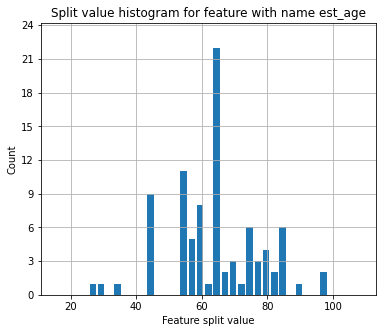

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (6, 5))5
lgb.plot_split_value_histogram(clf_list['LGBMClassifier_1000x3 v5'], ax=ax, feature='est_age')

In [ ]:
xgb_model = xgb.XGBClassifier(n_jobs=-1)

/home/ywang/miniconda3/envs/python36/lib/python3.6/site-packages/lightgbm/plotting.py:328: UserWarning: More than one metric available, picking one to plot.
  _log_warning("More than one metric available, picking one to plot.")


<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='binary_logloss'>

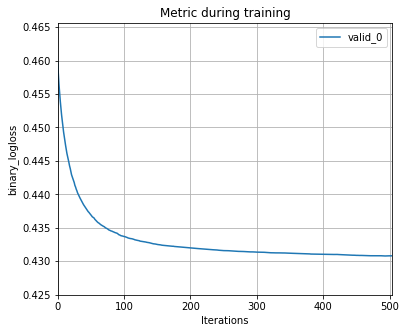

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (6, 5))
lgb.plot_metric(clf_list['LGBMClassifier_1000x3 v5'], ax=ax)

In [ ]:
clf_name = 'XGBClassifier'

In [ ]:
clf = GridSearchCV(xgb_model,
                   {'max_depth': [4, 6, 8],
                    'n_estimators': [50, 100, 200]}, verbose=1, n_jobs=2)

In [ ]:
clf.fit(X_train, y_train)

In [ ]:
print(clf.best_score_)
print(clf.best_params_)

# The sklearn API models are picklable
print("Pickling sklearn API models")

# must open in binary format to pickle
pickle.dump(clf, open(f'best_models/Best_{clf_name}.pk','wb'))
# clf2 = pickle.load(open("best_boston.pkl", "rb"))
# print(np.allclose(clf.predict(X), clf2.predict(X)))

In [ ]:
clf.best_params_

In [ ]:
print(f'----- Classification Report {clf_name} -----')
probability_train = clf.predict_proba(X_train)[:, 1]
probability_val = clf.predict_proba(X_val)[:, 1]
probability_test = clf.predict_proba(X_test)[:, 1]
predict_train = clf.predict(X_train)
predict_val = clf.predict(X_val)
predict_test = clf.predict(X_test)
T_val = evaluate_model(predict_train, predict_val, predict_test, probability_train, probability_val, probability_test, y_train, y_val, y_test, normalize=True, title=clf_name)

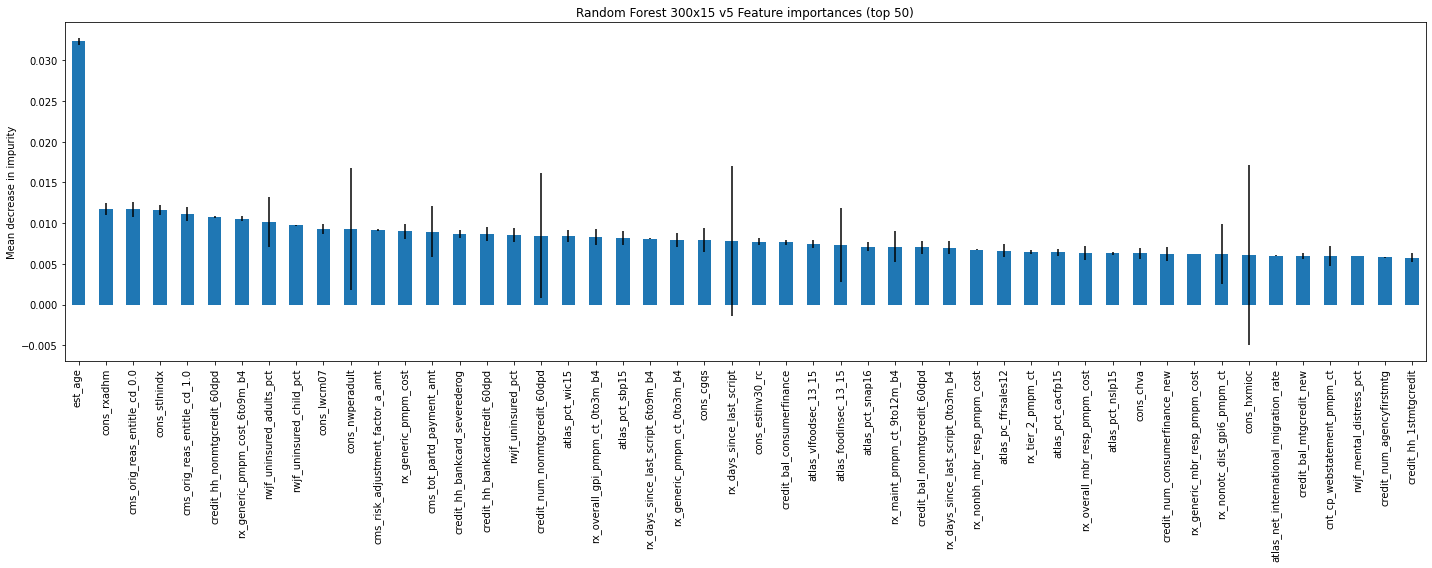

In [ ]:
name = 'Random Forest 300x15 v5'

importances = clf_list[name].feature_importances_
std = np.std([tree.feature_importances_ for tree in clf_list[name].estimators_], axis=0)
forest_importances = pd.Series(importances, index=X.columns).sort_values(ascending=False)[:50]
fig, ax = plt.subplots(figsize=(20,8))
forest_importances.plot.bar(yerr=std[:50], ax=ax)
ax.set_title(f"{name} Feature importances (top 50)")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
plt.savefig(f"plots/Top_50_features_{name.replace(' ', '_')}.pdf")

In [ ]:
forest_importances

est_age                                   0.032339
cons_rxadhm                               0.011790
cms_orig_reas_entitle_cd_0.0              0.011716
cons_stlnindx                             0.011618
cms_orig_reas_entitle_cd_1.0              0.011129
credit_hh_nonmtgcredit_60dpd              0.010703
rx_generic_pmpm_cost_6to9m_b4             0.010533
rwjf_uninsured_adults_pct                 0.010125
rwjf_uninsured_child_pct                  0.009756
cons_lwcm07                               0.009260
cons_nwperadult                           0.009249
cms_risk_adjustment_factor_a_amt          0.009162
rx_generic_pmpm_cost                      0.009021
cms_tot_partd_payment_amt                 0.008977
credit_hh_bankcard_severederog            0.008680
credit_hh_bankcardcredit_60dpd            0.008651
rwjf_uninsured_pct                        0.008535
credit_num_nonmtgcredit_60dpd             0.008478
atlas_pct_wic15                           0.008445
rx_overall_gpi_pmpm_ct_0to3m_b4